Forward Propagation для первого слоя:
$$ Z_1 = XW_1^T + b_1 $$
$$ A_1 = \sigma_1(Z_1) $$  
Forward Propagation для остальных слоёв:  
$$ Z_i = A_{i - 1}W_i^T + b_1 $$
$$ A_i = \sigma_{i}(Z_i) $$  
Backward Propagation для последнего слоя (n): 
$$dZ_{n} = \frac{\partial L}{\partial Z_{n}} = \frac{\partial L}{\partial \hat{y}} \times \frac{\partial \hat{y}}{\partial Z_{n}} = dL \times (\hat{y}(1 - \hat{y})) $$
$$dW_n = (\frac{\partial L}{\partial Z_n})^T \circ \frac{\partial Z_n}{\partial W_n} = dZ_n^T \circ A^{n - 1} $$  
$$db_n = (\frac{\partial L}{\partial Z_n})^T \circ \frac{\partial Z_n}{\partial b_n} = dZ_n^T \circ E $$  
Backward Propagation для скрытых слоёв:   
$$dZ_{i} = \frac{\partial L}{\partial Z_{i}} = \frac{\partial L}{\partial A_i} \times \frac{\partial A_i}{\partial Z_{i}} = (\frac{\partial L}{\partial Z_{i + 1}}\circ\frac{\partial Z_{i + 1}}{\partial A_i})\times\frac{\partial A_i}{\partial Z_i} = (dZ_{i + 1} \circ W_{i + 1}) \times \frac{\partial A_i}{\partial Z_i} $$
$$dW_i = (\frac{\partial L}{\partial Z_i})^T \circ \frac{\partial Z_i}{\partial W_i} = dZ_i^T \circ A^{i - 1} $$  
$$db_i = (\frac{\partial L}{\partial Z_i})^T \circ \frac{\partial Z_i}{\partial b_i} = dZ_i^T \circ E $$  
Backward Propagation первого слоя:   
$$dZ_{1} = \frac{\partial L}{\partial Z_{1}} = \frac{\partial L}{\partial A_1} \times \frac{\partial A_1}{\partial Z_{1}} = (\frac{\partial L}{\partial Z_{2}}\circ\frac{\partial Z_{2}}{\partial A_1})\times\frac{\partial A_1}{\partial Z_1} = (dZ_{2} \circ W_{2}) \times \frac{\partial A_1}{\partial Z_1} $$  
$$dW_1 = (\frac{\partial L}{\partial Z_i})^T \circ \frac{\partial Z_i}{\partial W_1} = dZ_1^T \circ X $$
$$db_1 = (\frac{\partial L}{\partial Z_1})^T \circ \frac{\partial Z_1}{\partial b_1} = dZ_1^T \circ E $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import os

In [2]:
def load_planar_dataset(m=400):
    np.random.seed(1)
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [3]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    X = X.T
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

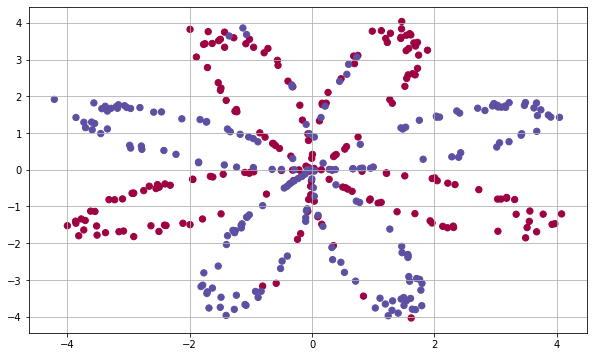

In [4]:
X, Y = load_planar_dataset() #загружаем датасет
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(X[:,0], X[:,1], c=Y[:,0], s=40, cmap=plt.cm.Spectral);

In [5]:
class MultiLayersNN:
    def __init__(self, n_input, n_hidden, activation_funs):
        self.layers = len(n_hidden) + 1
        self.params = {}
        self.gradients = {}
        self.act_funs = []
        self.grad_act_funs = []
        self.cache = {}
        self.ewa = {}
        
        self._initialize_params(n_input, n_hidden)
        self._initialize_activations(activation_funs)

    def _initialize_params(self, n_input, n_hidden):
        self.params["w1"] = np.random.randn(n_hidden[0], n_input)
        self.params["b1"] = np.zeros((n_hidden[0],))
        self.cache["a1"] = None
        self.cache["z1"] = None
        self.cache["X"] = None
        
        for i in range(1, self.layers - 1):
            self.params["w" + str(i + 1)] = np.random.randn(n_hidden[i], n_hidden[i-1])
            self.params["b" + str(i + 1)] = np.zeros((n_hidden[i],))
            self.cache["a" + str(i + 1)] = None
            self.cache["z" + str(i + 1)] = None
        
        self.params["w" + str(self.layers)] = np.random.randn(1, n_hidden[self.layers - 2])
        self.params["b" + str(self.layers)] = np.zeros((1,))
        self.cache["a" + str(self.layers)] = None
        self.cache["z" + str(self.layers)] = None
        
        for i in range(0, self.layers):
            self.ewa["Vdw" + str(i + 1)] = 0
            self.ewa["Vdb" + str(i + 1)] = 0

        for key in self.params.keys():
            self.gradients['d' + key] = np.zeros_like(self.params[key])
            
    
    def _initialize_activations(self, activation_funs):
        for i, act_fun in enumerate(activation_funs):
            if act_fun == "tanh":
                self.act_funs.append(np.tanh)
                self.grad_act_funs.append(lambda x: 1 - np.tanh(x)**2)
            if act_fun == "sigmoid":
                self.act_funs.append(self.sigmoid)
                self.grad_act_funs.append(lambda x: self.sigmoid(x)*(1.-self.sigmoid(x)))
                
    @staticmethod
    def sigmoid(z):
        return np.where(
            z >= 0,
            1 / (1 + np.exp(-z)), 
            np.exp(z) / (1 + np.exp(z))
        )

#Forward Propagation

    #Для одного слоя
    def layer_forward(self, a_previous, i):
        z = a_previous @ self.params["w" + str(i)].T + self.params["b" + str(i)]
        a_current = self.act_funs[i - 1](z)
        self.cache["a" + str(i)] = a_current
        self.cache["z" + str(i)] = z
        return a_current
        pass
    
    #Для всех слоёв
    def forward(self, X):
        self.cache['X'] = X
        a_current = X
        for i in range(1, self.layers + 1):
            a_current = self.layer_forward(a_current, i)
        return a_current
    
    def __call__(self, X):
        return self.forward(X)

#Backward Propagation
    
    #Для одного слоя
    def layer_backward(self, dz, i):
        z = self.cache["z" + str(i + 1)]
        if i == 0:
            a_previous = self.cache["X"]
        if i != 0:    
            a_previous = self.cache["a" + str(i)]
        dz_previous = (dz @ self.params["w" + str(i + 2)]) * self.grad_act_funs[i + 1](z)
        dw_previous = dz_previous.T @ a_previous
        db_previous = dz_previous.T @ np.ones(a_previous.shape[0])
        self.gradients["dw" + str(i + 1)] = dw_previous
        self.gradients["db" + str(i + 1)] = db_previous
        return dz_previous, dw_previous, db_previous

    #Для всех слоёв
    def backward(self, dL):
        X = self.cache['X']
        z = self.cache["z" + str(self.layers)]
        a = self.cache["a" + str(self.layers)]
        a_previous = self.cache["a" + str(self.layers - 1)]
        dz = dw = db =None
        
        dz = dL * (a * (1. - a))
        dw = dL.T @ a_previous
        db = dL.T @ np.ones((z.shape[0]))
        self.gradients["dw" + str(self.layers)] = dw
        self.gradients["db" + str(self.layers)] = db

        for i in range(self.layers - 2, -1, -1):
            dz, dw, db = self.layer_backward(dz, i)
    
    #Momentum
    def momentum(self, dL, B):
        X = self.cache['X']
        z = self.cache["z" + str(self.layers)]
        a = self.cache["a" + str(self.layers)]
        a_previous = self.cache["a" + str(self.layers - 1)]
        dz = dw = db = None
        
        dz = dL * (a * (1. - a))
        dw = dL.T @ a_previous
        db = dL.T @ np.ones((z.shape[0]))
        self.gradients["dw" + str(self.layers)] = dw
        self.gradients["db" + str(self.layers)] = db
        self.ewa["Vdw" + str(self.layers)] = B * self.ewa["Vdw" + str(self.layers)] + (1 - B) * dw
        self.ewa["Vdb" + str(self.layers)] = B * self.ewa["Vdb" + str(self.layers)] + (1 - B) * db
            
        for i in range(self.layers - 2, -1, -1):
            dz, dw, db = self.layer_backward(dz, i)
            self.ewa["Vdw" + str(i + 1)] = B * self.ewa["Vdw" + str(i + 1)] + (1 - B) * dw
            self.ewa["Vdb" + str(i + 1)] = B * self.ewa["Vdb" + str(i + 1)] + (1 - B) * db


    def summary(self):
        num_layers = len(self.params)//2
        for i in range(1, num_layers + 1):
            w_ind, b_ind = f'w{i}', f'b{i}'
            print(f"Layer_{i}\t weights shape: {self.params[w_ind].shape}\t bias shape: {self.params[b_ind].shape}")

In [6]:
class Optimizer:
    def __init__(self, regression_class, batches, lr=1e-2):
        self.model = regression_class
        self.lr = lr
        self.batches = batches
        self.x_batches = []
        self.y_batches = []
        
    def step(self):
        new_params = {
            k: None for k in self.model.params
        }
        params = self.model.params
        grads = self.model.gradients
        
        for key in self.model.params.keys():
            new_params[key] = params[key] - self.lr * grads["d"+key]
        self.model.params = new_params
        
    # Аналогично step(), но вместо градиентов скользящее среднее
    def momentum_step(self):
        new_params = {
            k: None for k in self.model.params
        }
        params = self.model.params
        ewa = self.model.ewa
        
        for key in self.model.params.keys():
            new_params[key] = params[key] - self.lr * ewa["Vd"+key]
        self.model.params = new_params

    def zero_grad(self):
        for key in self.model.gradients.keys():
            self.model.gradients[key] = np.zeros_like(self.model.gradients[key])
           
    # Создание батчей 
    def create_mini_batches(self, X, Y):
        batch_size = int(len(X) / self.batches)
        X_Y = np.hstack((X,Y))
        np.random.shuffle(X_Y)
        for i in range(0, self.batches):
            mini_batch = X_Y[i * batch_size:(i + 1)*batch_size, :]
            self.x_batches.append(mini_batch[:, :-1])
            self.y_batches.append(mini_batch[:, -1].reshape((-1, 1)))
        if X_Y.shape[0] % batch_size != 0:
            mini_batch = X_Y[i * batch_size:X_Y.shape[0]]
            self.x_batches.append(mini_batch[:, :-1])
            self.y_batches.append(mini_batch[:, -1].reshape((-1, 1)))      

In [7]:
class Loss:
    def __init__(self, model, loss_fn, loss_fn_bw):
        self.model = model
        self.loss_fn = loss_fn
        self.loss_fn_bw = loss_fn_bw
        self.dL = None
        self.a = None
        self.y = None
    
    
    def __call__(self, a, y):
        self.a = a
        self.y = y
        return self.loss_fn(a, y)
    
    
    def forward(self, a, y):
        return self.__call__(a, y)
    
    
    def backward(self, **params):
        assert (self.a is not None) and (self.y is not None), "loss.forward() must be called first!"
        self.dL = self.loss_fn_bw(self.a, self.y)
        self.model.backward(self.dL, **params)
    

    def momentum(self, B, **params):
        assert (self.a is not None) and (self.y is not None), "loss.forward() must be called first!"
        self.dL = self.loss_fn_bw(self.a, self.y)
        self.model.momentum(self.dL, B, **params)

        
def binary_crossentropy(a, y, eps=1e-5):
    return -( y*np.log(eps+a) + (1. - y)*np.log(eps+1. - a)).mean()

def binary_crossentropy_bw(a, y, eps=1e-5):
    return -1./len(a)*((y-a)/ (eps+ a*(1.-a)))

In [8]:
X, y = load_planar_dataset(m=1000)

#Деление на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

#Количество нейронов в скрытых слоях
n_hidden = [3, 5, 4]

#Функции активации (tanh, sigmoid)
activation_funs = ['sigmoid', 'tanh', 'tanh', 'sigmoid']

#Количество подвыборок
batches = 3

model = MultiLayersNN(n_input=2, n_hidden=n_hidden, activation_funs=activation_funs)
optimizer = Optimizer(model, lr=1e-2, batches=batches)
loss = Loss(model, binary_crossentropy, binary_crossentropy_bw)
model.summary()

Layer_1	 weights shape: (3, 2)	 bias shape: (3,)
Layer_2	 weights shape: (5, 3)	 bias shape: (5,)
Layer_3	 weights shape: (4, 5)	 bias shape: (4,)
Layer_4	 weights shape: (1, 4)	 bias shape: (1,)


In [10]:
num_epochs = 15000
epoches = [i for i in range(1, num_epochs + 1)]
sum = 0;
loss_average = []
loss_val = []
for i in range(num_epochs):
    optimizer.create_mini_batches(X_train, y_train)
    for j in range(optimizer.batches):
      a = model(optimizer.x_batches[j])
      l = loss(a, optimizer.y_batches[j])
      sum += l
      loss.momentum(B = 0.9)
      optimizer.momentum_step()
      optimizer.zero_grad()
    loss_average.append(sum / optimizer.batches)
    sum = 0
    a_val = model(X_test)
    loss_val.append(loss(a_val, y_test))

    if (i % 400 == 0):
        a = model(X_train)
        l = loss(a, y_train)
        print("Epoch %d/%d\t Loss: %.3f"%(i, num_epochs, l), end='\t')
        print("Accuracy: %.3f"%(accuracy_score(y_train, a>0.5)), end='\t')
        print("Val_loss: %.3f"%(loss(a_val, y_test)), end='\t')
        print("Val_accuracy: %.3f"%(accuracy_score(y_test, a_val>0.5)))

Epoch 0/15000	 Loss: 0.927	Accuracy: 0.543	Val_loss: 0.927	Val_accuracy: 0.576
Epoch 400/15000	 Loss: 0.343	Accuracy: 0.855	Val_loss: 0.361	Val_accuracy: 0.844
Epoch 800/15000	 Loss: 0.302	Accuracy: 0.884	Val_loss: 0.319	Val_accuracy: 0.876
Epoch 1200/15000	 Loss: 0.287	Accuracy: 0.881	Val_loss: 0.302	Val_accuracy: 0.860
Epoch 1600/15000	 Loss: 0.277	Accuracy: 0.887	Val_loss: 0.288	Val_accuracy: 0.872
Epoch 2000/15000	 Loss: 0.268	Accuracy: 0.889	Val_loss: 0.275	Val_accuracy: 0.884
Epoch 2400/15000	 Loss: 0.260	Accuracy: 0.904	Val_loss: 0.263	Val_accuracy: 0.888
Epoch 2800/15000	 Loss: 0.253	Accuracy: 0.904	Val_loss: 0.255	Val_accuracy: 0.892
Epoch 3200/15000	 Loss: 0.248	Accuracy: 0.909	Val_loss: 0.248	Val_accuracy: 0.892
Epoch 3600/15000	 Loss: 0.246	Accuracy: 0.911	Val_loss: 0.244	Val_accuracy: 0.900
Epoch 4000/15000	 Loss: 0.244	Accuracy: 0.909	Val_loss: 0.242	Val_accuracy: 0.904
Epoch 4400/15000	 Loss: 0.243	Accuracy: 0.904	Val_loss: 0.241	Val_accuracy: 0.900
Epoch 4800/15000	 Los

Decision Boundary


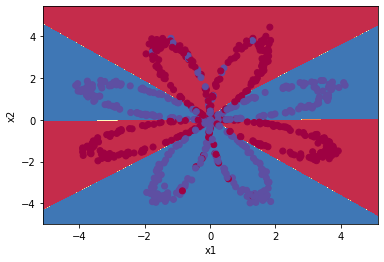

In [11]:
print("Decision Boundary")
plot_decision_boundary(lambda x: model(x)>0.5, X_train, y_train)

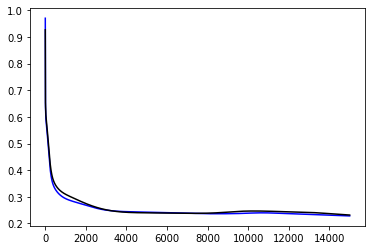

In [12]:
plt.plot(epoches, loss_average, color='b')
plt.plot(epoches, loss_val, color='0')

Поскольку график тренировочных данных (синий) и график тестовых данных (фиолетовый) практически совпадают, и не заметно существенного возрастания второго графика после достижения наименьшего значения функции потерь, то можно сказать, что переобучение отсутствует.